<a href="https://colab.research.google.com/github/AditiCoderElite/Multiple-Linear-Regression/blob/main/Multiple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Linear Regression

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


csv_file = 'https://s3-student-datasets-bucket.whjr.online/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)


df = df.dropna()


dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)


df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

year_series = dt_series.dt.year


month_series = dt_series.dt.month


day_series = dt_series.dt.day


day_name_series = dt_series.dt.day_name()


df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series


df = df.sort_values(by='DateTime')


def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series


cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in cols_to_correct:
    df[col] = comma_to_period(df[col])


df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)


aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]


for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)


for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)


group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')


df = pd.concat([aq_2004_df, aq_2005_df])


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int32         
 11  Month          9357 non-null   int32         
 12  Day            9357 non-null   int32         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int32(3), object(1)
memory usage: 986.9+ KB

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

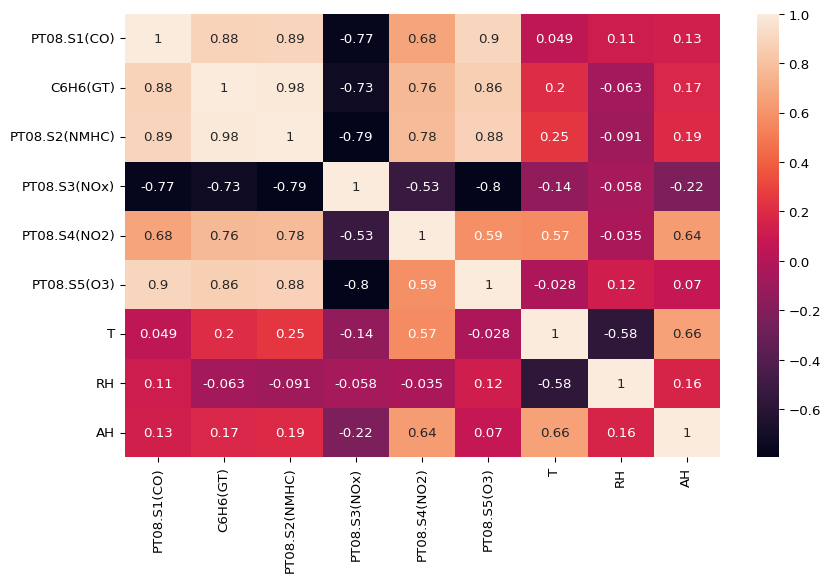

In [2]:
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True)
plt.show()

---

#### Multiple Linear Regression Model Using `sklearn` Module



In [3]:

features = list(df.columns.values[1:-1])
features.remove('RH')
features

['PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'PT08.S3(NOx)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'AH',
 'Year',
 'Month',
 'Day']

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df[features]
y = df['RH']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)


sklearn_lin_reg = LinearRegression()
sklearn_lin_reg.fit(X_train, y_train_reshaped)


print("\nConstant".ljust(15, " "), f"{sklearn_lin_reg.intercept_[0]:.6f}")


for item in list(zip(X.columns.values, sklearn_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.6f}")


Constant       -15028.451823
PT08.S1(CO)     0.014833
C6H6(GT)        -0.903464
PT08.S2(NMHC)   -0.005881
PT08.S3(NOx)    0.001503
PT08.S4(NO2)    0.026497
PT08.S5(O3)     -0.001066
T               -2.354919
AH              29.551742
Year            7.505153
Month           1.167861
Day             0.035232


In [5]:

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = sklearn_lin_reg.predict(X_train)
y_test_pred = sklearn_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 35.116
Root Mean Squared Error: 5.926
Mean Absolute Error: 4.572


Test Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 34.702
Root Mean Squared Error: 5.891
Mean Absolute Error: 4.564


---

In [6]:

X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

In [7]:

import statsmodels.api as sm


X_train_sm = sm.add_constant(X_train)


sm_lin_reg = sm.OLS(y_train, X_train_sm).fit()

sm_lin_reg.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

In [8]:

print(sm_lin_reg.params.values[0] - sklearn_lin_reg.intercept_[0])
print(sm_lin_reg.params.values[1:] - sklearn_lin_reg.coef_)

3.65729647455737e-07
[[ 5.28292687e-14  9.94915261e-12 -1.16788523e-13 -1.03046478e-13
  -3.15341503e-13 -5.23843122e-15 -3.28626015e-14  8.74287309e-11
  -1.82292403e-10 -1.58146829e-11 -8.20191137e-13]]


In [9]:

print(sm_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:49:45   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118